/Users/lgarcia/code/dev/nuance/nuance/utils.py:27: RuntimeWarning: divide by zero encountered in divide
  _t = P * np.sin(np.pi * (t - t0) / P) / (np.pi * D)
/Users/lgarcia/code/dev/nuance/nuance/star.py:56: RuntimeWarning: invalid value encountered in divide
  return (orbital_period * self.radius) / (np.pi * a)
/Users/lgarcia/code/dev/nuance/nuance/star.py:56: RuntimeWarning: invalid value encountered in divide
  return (orbital_period * self.radius) / (np.pi * a)
/Users/lgarcia/code/dev/nuance/nuance/star.py:56: RuntimeWarning: invalid value encountered in divide
  return (orbital_period * self.radius) / (np.pi * a)
/Users/lgarcia/code/dev/nuance/nuance/star.py:56: RuntimeWarning: invalid value encountered in divide
  return (orbital_period * self.radius) / (np.pi * a)
/Users/lgarcia/code/dev/nuance/nuance/star.py:56: RuntimeWarning: invalid value encountered in divide
  return (orbital_period * self.radius) / (np.pi * a)


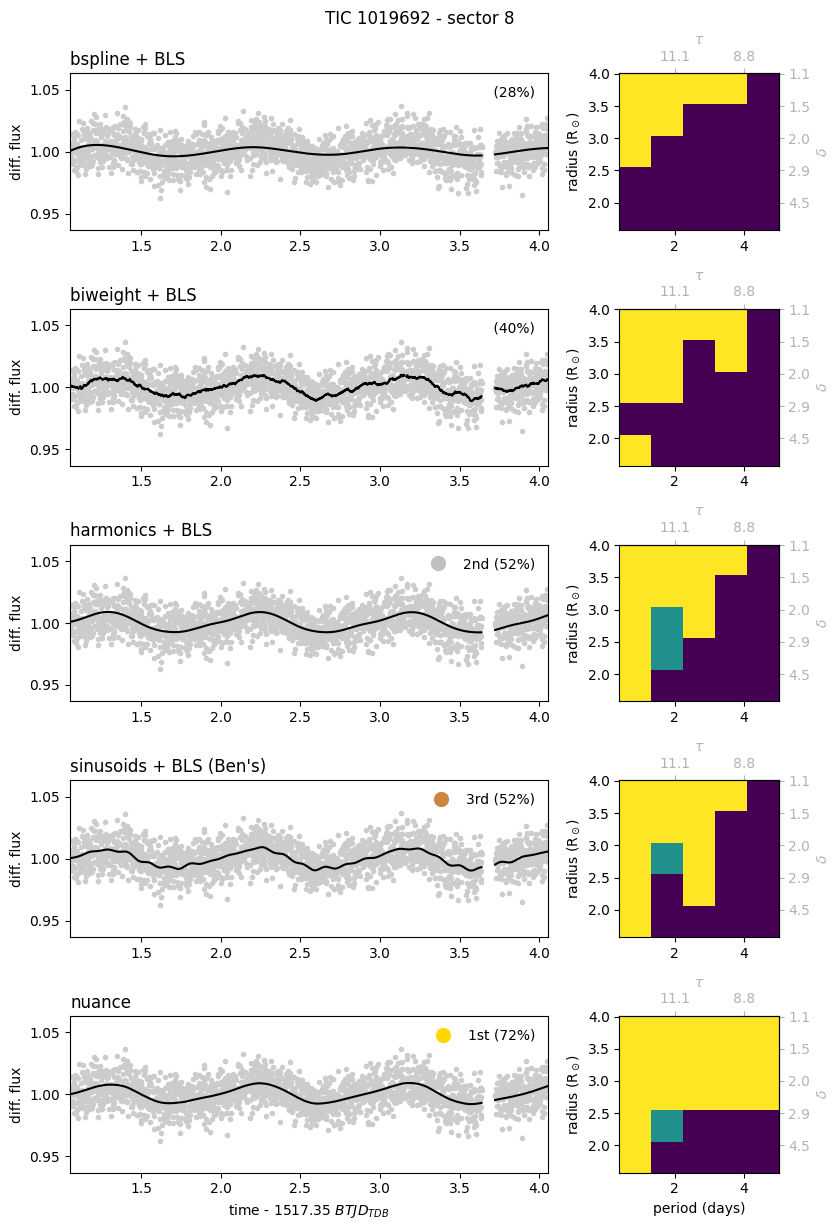

In [17]:
import pickle

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import yaml
from matplotlib import gridspec
from nuance.star import Star


tic =  1019692
raw_data = f"../data/{tic}/original.fluxes"
data_path = f"../data/{tic}/cleaned.fluxes"
gp_path = f"../data/{tic}/gp.yaml"
info_path = f"../data/{tic}/info.yaml"


original_data = pickle.load(open(raw_data, "rb"))
data = pickle.load(open(data_path, "rb"))
gp_params = yaml.full_load(open(gp_path, "r"))
info = yaml.full_load(open(info_path, "r"))

methods = {
    "bls_bspline": "bspline + BLS",
    "bls_wotan3D": "biweight + BLS",
    "bls_harmonics": "harmonics + BLS",
    "bens": "sinusoids + BLS (Ben's)",
    "nuance": "nuance",
}


results = {
    method: f"../data/{tic}/recovered/{method}/results.csv"
    for i, method in enumerate(methods)
}
first_recovered = {
    method: f"../data/{tic}/recovered/{method}/0.params"
    for i, method in enumerate(methods)
}

n_methods = len(methods)

from nuance import Nuance
from nuance.kernels import rotation

n = 5

split_idxs = [
    0,
    *np.flatnonzero(np.diff(data["time"]) > 10 / 60 / 24),
    len(data["time"]),
]

# nuance trend
build_gp, _ = rotation(info["star_period"])
nu = Nuance(data["time"], data["flux"], gp=build_gp(gp_params, data["time"]))
nuance_trend = np.sum(nu.models(0, 0, 1), 0)


def right_candidate(t0, period, true_t0, true_period, verbose=False):
    t0_check = (
        np.abs((t0 - true_t0 + 0.5 * true_period) % true_period - 0.5 * true_period)
        % period
        < 0.01
    )
    period_check = np.abs(period - true_period) <= 0.01
    alias_check = np.abs(2 * period - true_period) <= 0.01
    alias_check |= np.abs(period / 2 - true_period) <= 0.01
    if period_check:
        return 1
    elif alias_check:
        return 0.5
    else:
        return 0

total_found = {}
for method in methods.keys():
    df = pd.read_csv(results[method])
    df["found"] = df.apply(
        lambda row: right_candidate(
            row["t0"], row["period"], row["true_t0"], row["true_period"]
        ),
        axis=1,
    )
    total_found[method] = np.count_nonzero(df.found)

# sorted name of methods total_found
sorted_methods = sorted(total_found, key=total_found.get, reverse=True)
ranks = {name: i for i, name in enumerate(sorted_methods)}

star = Star(
    info["star_radius"], info["star_mass"], info["star_amplitude"], info["star_period"]
)
sec_color = "0.7"

# grid of plot with ratio 1:3
fig, axes = plt.subplots(
    nrows=len(methods),
    ncols=2,
    gridspec_kw={"width_ratios": [3, 1]},
    figsize=(8.5, 2.5 * n_methods),
)
for i, (method, title) in enumerate(methods.items()):
    ax = axes[i, 1]
    df = pd.read_csv(results[method])
    if method == "nuance":
        trend = nuance_trend
    else:
        trend = pickle.load(open(first_recovered[method], "rb"))["trend"]
    df["found"] = df.apply(
        lambda row: right_candidate(
            row["t0"], row["period"], row["true_t0"], row["true_period"]
        ),
        axis=1,
    )
    radius, period, found, tau, delta = df[
        ["radius", "true_period", "found", "tau", "delta"]
    ].values.T

    # setting up ranges
    taus_range = np.min(tau), np.max(tau)
    deltas_range = np.min(delta), np.max(delta)
    periods_range = np.min(period), np.max(period)
    radii_range = np.min(radius), np.max(radius)
    extent = (*periods_range, *radii_range)

    ax.imshow(
        found.reshape((n, n)),
        extent=[*periods_range, *radii_range],
        aspect="auto",
        cmap="viridis",
        origin="lower",
    )


    secax = ax.secondary_yaxis("right")
    radii_ticks = ax.get_yticks()
    delta_ticks = star.radius2delta(radii_ticks)
    secax.set_yticks(radii_ticks, [f"{t:.1f}" for t in delta_ticks])
    secax.set_ylabel(r"$\delta$", color=sec_color)
    secax.tick_params(axis="y", colors=sec_color)

    secax = ax.secondary_xaxis("top")
    period_ticks = ax.get_xticks()
    tau_ticks = star.period2tau(period_ticks)
    secax.set_xticks(period_ticks, [f"{t:.1f}" for t in tau_ticks])
    secax.set_xlabel(r"$\tau$", color=sec_color)
    secax.tick_params(axis="x", colors=sec_color)
    ax.set_ylabel("radius (R$_\odot$)")

    # plotting data and trend
    ax = axes[i, 0]
    ax.plot(data["time"], data["flux"], ".", c="0.8")
    if trend is not None:
        for i in range(len(split_idxs) - 1):
            x = data["time"][split_idxs[i] + 1 : split_idxs[i + 1]]
            y = trend[split_idxs[i] + 1 : split_idxs[i + 1]]
            ax.plot(x, y, "k", label="trend" if method != "nuance" else "GP mean")

    ax.set_xlim(np.array([0, 3]) + data["time"][0])
    ax.set_ylabel("diff. flux")
    ax.set_title(title, loc="left")
    legend_elements = [
        plt.Line2D(
            [],
            [],
            marker="o",
            color="w",
            markersize=12,
            markerfacecolor=[
                "gold",
                "silver",
                "peru",
                *["white" for _ in range(n_methods - 3)],
            ][ranks[method]],
        )
    ]
    legend_labels = [
        ["1st", "2nd", "3rd", *["" for _ in range(n_methods - 3)]][ranks[method]]
        + f" ({int(total_found[method]/len(found)*100)}%)"
    ]
    ax.legend(
        legend_elements,
        legend_labels,
        loc="upper right",
        frameon=False,
    )
    ylim = np.std(data["flux"]) * 5.5
    ax.set_ylim(1 - ylim, 1 + ylim)

axes[-1, 1].set_xlabel("period (days)")
axes[-1, 0].set_xlabel(f"time - {info['time0']:.2f} ${info['time0_format']}$")
fig.suptitle(f"TIC {tic} - sector {info['sector']}")

plt.tight_layout()


In [8]:
periods_range

(0.4, 5.0)